In [9]:
import numpy as np
from numpy import number
from scipy.linalg import solve_banded
import matplotlib.pyplot as plt

In [10]:
q, V, w = 2, 4, 1

alpha, beta = 0, 0
a, b, end_time = -20, 20, 1

N, T = 501, 201

x = np.linspace(a, b, N)
dx = (b-a)/(N-1)

t = np.linspace(0, end_time, T)
dt = end_time/(T-1)

In [11]:
u_exact = w * np.sqrt(2./q) * np.exp(1j * (0.5 * V * np.ones((T, 1)) * x.reshape((1, N)) - 0.25 * (V * V - w * w) * t.reshape((T, 1)) * np.ones((1, N))))
u_exact = u_exact / np.cosh(w * (np.ones((T, 1)) * x.reshape((1, N)) - V * t.reshape((T, 1)) * np.ones((1, N))))

In [12]:
def implicit_step(u, _dx, _dt, _q, _alpha, _beta):
    
    dx2 = _dx**2
    c = -0.5 * 1j * _dt/dx2
    d = 1j * _dt / dx2
    g = 0.5 * 1j * _dt * _q

    n = np.size(u)
    # assign 3-diagonal matrix
    _a = np.zeros((3, n), dtype=np.complex_)
    # top diagonal
    _a[0, 1:] = c

    # main diagonal
    _a[1, 0] = 1 - c - g * np.square(np.abs(u[0]))
    _a[1, 1:-1] = 1 + d - g * np.square(np.abs(u[1:-1]))
    _a[1, n-1] = 1 - c - g * np.square(np.abs(u[n-1]))

    # lower diagonal
    _a[2, :-1] = c

    # assign NLS(rhs)
    f = np.zeros(n, dtype=np.complex_)
    f[0] = u[0] - c * (u[1] - u[0] - 2 * dx * _alpha) + g * np.square(np.abs(u[0])) * u[0]
    f[1:-1] = u[1:-1] - c * (u[2:] - 2 * u[1:-1] + u[:-2]) + g * np.square(np.abs(u[1:-1])) * u[1:-1]
    f[n-1] = u[n-1] - c * (2 * dx * _beta - u[n-1] + u[n-2]) + g * np.square(np.abs(u[n-1])) * u[n-1]

    return solve_banded((1, 1), _a, f)

In [13]:
def fdm_cn_solution(u0, _dx, _dt, _q, _alpha, _beta, time_steps):
  
    n = np.size(u0)  # number of nodes = N + 1, where N is the number of segments
    u = np.zeros((time_steps, n), dtype=np.complex_)  # solution

    # Initial condition
    u[0, :] = u0

    # solve by direct calculations with time stepping for spacial nodes
    for _t in range(time_steps-1):
        u[_t+1, :] = implicit_step(u[_t, :], _dx, _dt, _q, _alpha, _beta)

    return u

In [14]:
def L2_error(exact, numerical):
    return np.sqrt(np.sum(np.square(np.abs(exact - numerical))))


def Lmax_error(exact, numerical):
    return np.max(np.abs(exact - numerical))

In [15]:
print('Solving NLS with Crank-Nicolson Scheme...')
u_CN = fdm_cn_solution(u_exact[0, :], dx, dt, q, alpha, beta, T)

Solving NLS with Crank-Nicolson Scheme...


Time = 0.25
Errors with complex values
L2_Error_cn = 0.9532556354766616
L_max_Error_cn = 0.19269864268732645
-----------------------------------
Errors with absolute values
L2_abs_Error_cn = 0.02239849175496284
L_max_abs_Error_cn = 0.0052405058267885885
------------------------------------


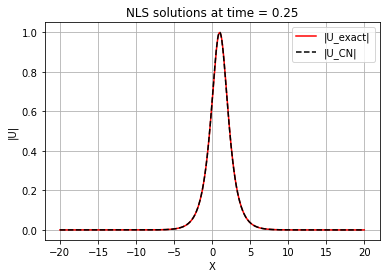

Time = 0.5
Errors with complex values
L2_Error_cn = 1.899923507583598
L_max_Error_cn = 0.383057890232397
-----------------------------------
Errors with absolute values
L2_abs_Error_cn = 0.04989431276974814
L_max_abs_Error_cn = 0.010972855705296936
------------------------------------


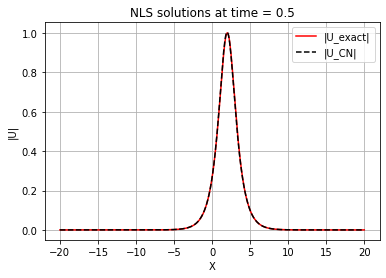

Time = 0.75
Errors with complex values
L2_Error_cn = 2.832015415418485
L_max_Error_cn = 0.5705159920749293
-----------------------------------
Errors with absolute values
L2_abs_Error_cn = 0.08009271839839065
L_max_abs_Error_cn = 0.016670692214744487
------------------------------------


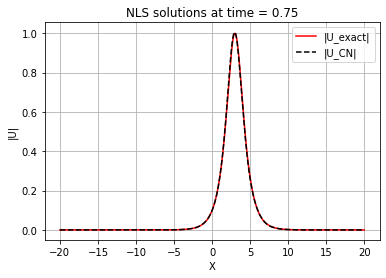

Time = 1.0
Errors with complex values
L2_Error_cn = 3.740797908392474
L_max_Error_cn = 0.7526486538797811
-----------------------------------
Errors with absolute values
L2_abs_Error_cn = 0.11279084085842689
L_max_abs_Error_cn = 0.022528888311000306
------------------------------------


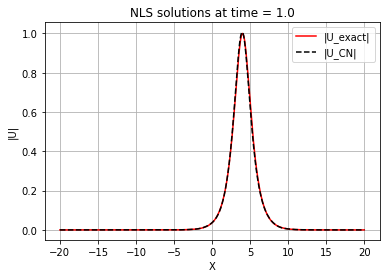

In [16]:
check_times = [1/4, 1/2, 3/4, 1.0]

for time in check_times:
    u_ex = u_exact[int((T-1) * time), :]
    u_sol_cn = u_CN[int((T-1) * time), :]
    
    print(f'Time = {end_time * time}')
    print('Errors with complex values')
    print(f'L2_Error_cn = {L2_error(u_ex, u_sol_cn)}')
    print(f'L_max_Error_cn = {Lmax_error(u_ex, u_sol_cn)}')


    print('-----------------------------------')
    print('Errors with absolute values')
    print(f'L2_abs_Error_cn = {L2_error(np.abs(u_ex), np.abs(u_sol_cn))}')
    print(f'L_max_abs_Error_cn = {Lmax_error(np.abs(u_ex), np.abs(u_sol_cn))}')

    print('------------------------------------')
    plt.title(f'NLS solutions at time = {end_time * time}')
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('|U|')
    plt.plot(x, np.abs(u_ex), label='|U_exact|', c='r', ls='-')
    plt.plot(x,  np.abs(u_sol_cn), label='|U_CN|', c='k', ls='--')
    plt.legend()
    plt.show()